<a href="https://colab.research.google.com/github/Enzopadilha/tcc_2/blob/main/Novo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classificação de imagens médicas utilizando o framework MONAI**


#### Este notebook foi baseado em um exemplo de classificação de imagens com MONAI e o conjunto de dados foi o MedNIST.
Você pode encontrar este tutorial aqui: https://colab.research.google.com/drive/1wy8XUSnNWlhDNazFdvGBHLfdkGvOHBKe

## Como estou usando o colab para fazer a implementação do código a primeira etapa que devo fazer é localizar o caminho da base de dados.

In [1]:
from google.colab import drive
# filenames = "code7_jan_enriched_7.csv" #@param {type:"string"}
diretorio = "/content/drive/MyDrive/input/" #@param {type:"string"}
#separador = ";" #@param {type:"string"}
#encode = "utf-8" #@param {type:"string"}
drive.mount('/content/drive')
#low_memory = False
#decimal = ','

Mounted at /content/drive


# Teste me baseando no colab do MONAI - MedNIST_tutorial

## Agora vamos instalar o framework e suas dependencias.

In [2]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     |████████████████████████████████| 956 kB 30.5 MB/s 
     |████████████████████████████████| 15.0 MB 30.9 MB/s 
     |████████████████████████████████| 16.6 MB 20.1 MB/s 
     |████████████████████████████████| 70.6 MB 8.2 kB/s 
     |████████████████████████████████| 20.3 MB 1.2 MB/s 
     |████████████████████████████████| 95.3 MB 1.4 MB/s 
     |████████████████████████████████| 54.5 MB 57 kB/s 


In [3]:
# !git clone https://github.com/Project-MONAI/MONAI.git
# !cd MONAI/
# !pip install -e '.[all]'

## Importando as bibliotecas que serão utilizadas no código

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AsChannelFirst,
    Resize,
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 0.10.dev2227
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 2c2f6cdd24381d6618adc43699bea3974cf9391f
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Ler o conjunto de dados e mostrar quantas imagens temos no total, a dimensão dessas imagens, o nome das classes e quantos arquivos temos em cada classe.

### A base de dados estava dividida em duas pastas: treino e teste. Por isso juntei a pasta de teste com a de treino manualmente pelo meu computador. Ou seja, peguei as imagens que estavam nas classes da pasta de teste e coloquei elas em suas devidas classes na pasta de treino já que mais adiante faremos a divisão dos dados.

In [5]:
# teste me baseando no colab do MONAI - MedNIST

data_dir = '/content/drive/MyDrive/input/Training' 
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Número total de imagens:', num_total)
print("Dimensões da imagem:", image_width, "x", image_height)
print("Nomes dos rótulos:", class_names)
print("Contagem de rótulos:", [len(image_files[i]) for i in range(num_class)])

Número total de imagens: 3160
Dimensões da imagem: 453 x 437
Nomes dos rótulos: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Contagem de rótulos: [926, 937, 396, 901]


## Visualizar alguns tipos de tumores.

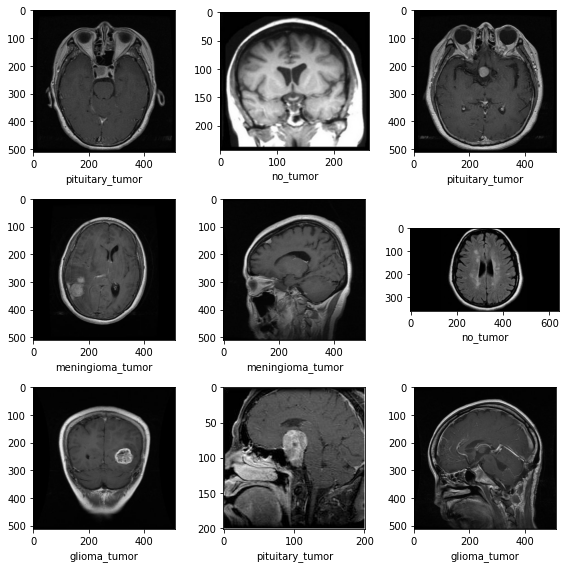

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Divisão dos dados em treino, validação e teste.

In [7]:
# 10% para validação e 10% para teste
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Contagem de treinamento =",len(trainX),"Contagem de validação =", len(valX), "Contagem de teste =",len(testX))

Contagem de treinamento = 2534 Contagem de validação = 304 Contagem de teste = 322


In [8]:
import os
import shutil
import tempfile
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

## Criar uma classe para transformar o tamanho da imagem.


In [9]:
class MyResize(Transform):
    def __init__(self, size=(80,80)):  
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

## Criar as transformação que serão aplicadas as imagens já inserindo a classe que foi criada anteriormente.

In [10]:
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(), 
    AddChannel(),    
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(), 
    AddChannel(),    
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.


## Definir uma classe para receber as transformações criadas e após esse passo criar variáveis para receber a classe com as transformações.

## Criar um *DataLoader* que é uma amostra dos dados.

In [11]:
class BrainDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = BrainDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

val_ds = BrainDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

test_ds = BrainDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=2)

## Definir a arquitetura de rede que será usada assim como a função de perda e otimizador.

In [12]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 100
val_interval = 1

## Colocar o modelo para treino

In [13]:
# Treinando o modelo

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"época {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"época {epoch + 1} perda média: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('salvou o novo melhor modelo métrico')
            print(f"época atual: {epoch + 1} atual AUC: {auc_result:.4f}"
                  f" acurácia atual: {acc_metric:.4f} melhor AUC: {best_metric:.4f}"
                  f" na época: {best_metric_epoch}")
print(f"treino concluído, melhor métrica: {best_metric:.4f} na época: {best_metric_epoch}")

----------
época 1/100
1/8, train_loss: 1.3539
2/8, train_loss: 1.3972
3/8, train_loss: 1.3451
4/8, train_loss: 1.3397
5/8, train_loss: 1.3299
6/8, train_loss: 1.3193
7/8, train_loss: 1.3202
8/8, train_loss: 1.3024
9/8, train_loss: 1.2906
época 1 perda média: 1.3332
salvou o novo melhor modelo métrico
época atual: 1 atual AUC: 0.5096 acurácia atual: 0.2928 melhor AUC: 0.2928 na época: 1
----------
época 2/100
1/8, train_loss: 1.2657
2/8, train_loss: 1.2603
3/8, train_loss: 1.2709
4/8, train_loss: 1.2571
5/8, train_loss: 1.2457
6/8, train_loss: 1.2300
7/8, train_loss: 1.2102
8/8, train_loss: 1.1968
9/8, train_loss: 1.2051
época 2 perda média: 1.2380
salvou o novo melhor modelo métrico
época atual: 2 atual AUC: 0.6591 acurácia atual: 0.3355 melhor AUC: 0.3355 na época: 2
----------
época 3/100
1/8, train_loss: 1.2147
2/8, train_loss: 1.1678
3/8, train_loss: 1.1795
4/8, train_loss: 1.1772
5/8, train_loss: 1.1886
6/8, train_loss: 1.1627
7/8, train_loss: 1.1547
8/8, train_loss: 1.1651
9/8, 

AUC

[O valor do AUC varia de 0,0 até 1,0 e o limiar entre a classe é 0,5. Ou seja, acima desse limite, o algoritmo classifica em uma classe e abaixo na outra classe.
Quanto maior o AUC, melhor.](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772)


## Plotar a função de perda e a métrica

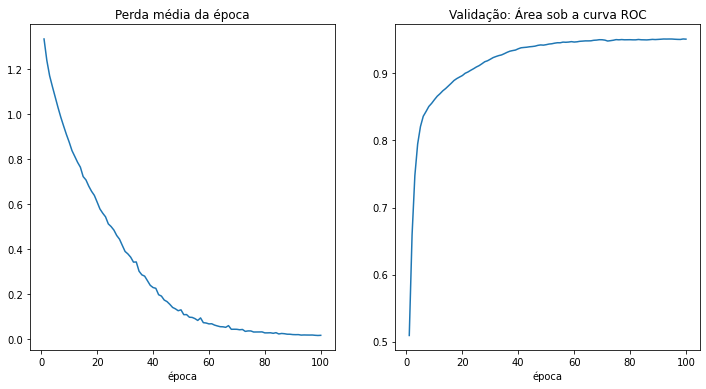

In [14]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Perda média da época")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('época')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validação: Área sob a curva ROC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('época')
plt.plot(x, y)
plt.show()

## Avalie o modelo no conjunto de dados de teste

In [15]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

## Resultado do modelo pelo relatório de classificação mostrando suas principais métricas.

In [16]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                  precision    recall  f1-score   support

    glioma_tumor     0.8072    0.7882    0.7976        85
meningioma_tumor     0.8043    0.7327    0.7668       101
        no_tumor     0.8723    0.8542    0.8632        48
 pituitary_tumor     0.8400    0.9545    0.8936        88

        accuracy                         0.8261       322
       macro avg     0.8310    0.8324    0.8303       322
    weighted avg     0.8250    0.8261    0.8240       322

